# Anemoi Training

## 1. Data Set

In [63]:
import xarray as xr

# Open the Zarr dataset
ds = xr.open_zarr("era_t2m.zarr", consolidated=True)

# Show dataset info
print(ds)

# Check shape of the main variable
print("Shape of 'data':", ds["data"].shape)

# Check time coordinate
print("Time coordinate:", ds["valid_time"].values)

<xarray.Dataset> Size: 804MB
Dimensions:     (valid_time: 31, latitude: 1801, longitude: 3600)
Coordinates:
  * latitude    (latitude) float64 14kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 29kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 248B 2025-01-01 ... 2025-01-31
Data variables:
    data        (valid_time, latitude, longitude) float32 804MB dask.array<chunksize=(4, 226, 450), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 2025-05-23T20:32 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts
Shape of 'data': (31, 1801, 3600)
Time coordinate: ['2025-01-01T00:00:00.000000000' '2025-01-02T00:00:00.000000000'
 '2025-01-03T00:00:00.0000000

## 2. Create Graph

In [64]:
import sys
sys.path.insert(0, "/home/rolan/all/anemoi-graphs/src")

In [65]:
from anemoi.graphs.create import GraphCreator
import anemoi.graphs.nodes
import os

builder_dir = "/home/rolan/all/anemoi-graphs/src/anemoi/graphs/nodes"
print("nodes available:", os.listdir(builder_dir))

nodes available: ['attributes.py', 'builders', '__init__.py', '__pycache__']


In [66]:
from omegaconf import OmegaConf
from anemoi.graphs.create import GraphCreator

config = OmegaConf.create({
    "nodes": {
        "ico_nodes": {
            "node_builder": {
                "_target_": "anemoi.graphs.nodes.builders.from_refined_icosahedron.TriNodes",
                "resolution": 4,  # more refined icosahedron, better global coverage
                "name": "ico_nodes"
            },
            "attributes": {}
        }
    },
    "edges": [
        {
            "source_name": "ico_nodes",
            "target_name": "ico_nodes",
            "edge_builders": [
                {
                    "_target_": "anemoi.graphs.edges.builder.KNNEdges",
                    "source_name": "ico_nodes",
                    "target_name": "ico_nodes",
                    "num_nearest_neighbours": 6
                }
            ]
        }
    ]
})

creator = GraphCreator(config)
graph = creator.create()

# Optional: check
print(graph)
print(graph.edge_types)
print(graph["ico_nodes", "to", "ico_nodes"])
print("edge_index" in graph["ico_nodes", "to", "ico_nodes"])

No output path specified. The graph will not be saved.


HeteroData(
  ico_nodes={
    x=[2562, 2],
    node_type='TriNodes',
  },
  (ico_nodes, to, ico_nodes)={
    edge_index=[2, 15372],
    edge_type='KNNEdges',
  }
)
[('ico_nodes', 'to', 'ico_nodes')]
{'edge_index': tensor([[   0,    1,    2,  ..., 2558, 2556, 2555],
        [   0,    0,    0,  ..., 2561, 2561, 2561]], dtype=torch.int32), 'edge_type': 'KNNEdges'}
True


## ERA To Graph

In [67]:
import torch
import math

# Get coordinates in radians (lon, lat)
x_rad = graph["ico_nodes"].x  # shape (N, 2)

# Convert radians to degrees
x_deg = x_rad * (180.0 / math.pi)

# Replace in the graph
graph["ico_nodes"].x = x_deg

# ✅ Done — check result
print("✅ First few node positions in degrees:")
print(graph["ico_nodes"].x[:5])


✅ First few node positions in degrees:
tensor([[ 90.0000,   0.0000],
        [ 86.0353, -90.0000],
        [ 86.0353,  90.0000],
        [ 85.5000, 148.2825],
        [ 85.5000,  31.7175]])


In [68]:
import xarray as xr

# Load the ERA5 Zarr dataset
ds = xr.open_zarr("era_t2m.zarr", consolidated=True)

# Extract one time step — e.g. January 1, 2025
era_t2m = ds["data"].sel(valid_time="2025-01-01T00:00:00", method="nearest")

# Check result
print("ERA T2M shape:", era_t2m.shape)
print("Latitude range:", ds.latitude.values[:3], "...", ds.latitude.values[-3:])
print("Longitude range:", ds.longitude.values[:3], "...", ds.longitude.values[-3:])


ERA T2M shape: (1801, 3600)
Latitude range: [90.  89.9 89.8] ... [-89.8 -89.9 -90. ]
Longitude range: [0.  0.1 0.2] ... [359.7 359.8 359.9]


In [69]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

# Get node positions (lon, lat) in degrees
node_coords = graph["ico_nodes"].x.numpy()  # shape (N, 2), in degrees

# ERA grid
lats = ds.latitude.values  # shape (1801,)
lons = ds.longitude.values  # shape (3600,)

# ERA data (lat, lon) -> values
field = era_t2m.values  # shape (1801, 3600)

# Build interpolator: ERA grid is (lat, lon) ordered!
interp_func = RegularGridInterpolator(
    (lats, lons), field, bounds_error=False, fill_value=np.nan
)

# Interpolation: swap to (lat, lon) for function input
interp_points = np.stack([node_coords[:, 1], node_coords[:, 0]], axis=-1)
node_values = interp_func(interp_points)  # shape (N,)

# Check result
print("✅ Interpolated t2m to graph nodes. Shape:", node_values.shape)
print("First values:", node_values[:5])

✅ Interpolated t2m to graph nodes. Shape: (2562,)
First values: [         nan 243.03459167          nan          nan 266.94851992]


In [70]:
# Define valid range with a small margin
lat_min, lat_max = lats.min() + 1e-4, lats.max() - 1e-4
lon_min, lon_max = lons.min() + 1e-4, lons.max() - 1e-4

# Clip node coordinates to valid bounds
clipped_coords = np.copy(node_coords)
clipped_coords[:, 0] = np.clip(clipped_coords[:, 0], lon_min, lon_max)  # lon
clipped_coords[:, 1] = np.clip(clipped_coords[:, 1], lat_min, lat_max)  # lat

# Interpolate again using clipped positions
interp_points = np.stack([clipped_coords[:, 1], clipped_coords[:, 0]], axis=-1)
node_values = interp_func(interp_points)

print("✅ Re-interpolated with clipping. NaNs:", np.isnan(node_values).sum())

✅ Re-interpolated with clipping. NaNs: 1412


In [71]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

# Extract data and coordinate arrays
t2m_all = ds["data"].values  # shape: (31, 1801, 3600)
lats = ds["latitude"].values
lons = ds["longitude"].values

# Ensure increasing order for interpolator (latitude in ERA is decreasing)
if lats[0] > lats[-1]:
    lats = lats[::-1]
    t2m_all = t2m_all[:, ::-1, :]  # flip latitude axis

# Create interpolator over ERA grid
interp_func = RegularGridInterpolator((lats, lons), np.zeros((len(lats), len(lons))), bounds_error=False, fill_value=np.nan)

# Prepare storage
num_timesteps = t2m_all.shape[0]
num_nodes = len(node_coords)
t2m_graph = np.full((num_timesteps, num_nodes), np.nan, dtype=np.float32)

# Loop over all time steps
for t in range(num_timesteps):
    interp_func.values = t2m_all[t]  # set new data for this time step
    t2m_graph[t] = interp_func(np.stack([node_coords[:, 1], node_coords[:, 0]], axis=-1))

print("✅ Done. Interpolated shape:", t2m_graph.shape)
print("NaNs in each time step:", np.sum(np.isnan(t2m_graph), axis=1))

✅ Done. Interpolated shape: (31, 2562)
NaNs in each time step: [2239 2239 2239 2239 2239 2239 2239 2239 2239 2239 2239 2239 2239 2239
 2239 2239 2239 2239 2239 2239 2239 2239 2239 2239 2239 2239 2239 2239
 2239 2239 2239]


In [72]:
import torch

# Step 1: Convert to PyTorch tensor
t2m_tensor = torch.tensor(t2m_graph, dtype=torch.float32)  # shape (31, 2562)

# Step 2: Mask for valid nodes (no NaNs across all times)
valid_mask = ~torch.any(torch.isnan(t2m_tensor), dim=0)  # shape (2562,)
valid_indices = torch.where(valid_mask)[0]

print(f"✅ Valid land nodes with full time series: {valid_indices.shape[0]}")

# Step 3: Extract only valid node data (no NaNs)
data_valid = t2m_tensor[:, valid_indices]  # shape (31, N_valid)

# Step 4: Create input-target pairs: (t, t+1)
X = data_valid[:-1]  # shape (30, N_valid)
Y = data_valid[1:]   # shape (30, N_valid)

print("✅ Prepared training data.")
print("X shape:", X.shape, "→ input at day t")
print("Y shape:", Y.shape, "→ target at day t+1")

✅ Valid land nodes with full time series: 323
✅ Prepared training data.
X shape: torch.Size([30, 323]) → input at day t
Y shape: torch.Size([30, 323]) → target at day t+1


In [73]:
import torch
torch.save(graph, "graph.pt")

# Registering Dataset With Anemoi

In [76]:
import zarr

# Open the Zarr store
z = zarr.open('era_t2m.zarr', mode='r')

# Print the metadata attributes
for key, value in z.attrs.items():
    print(f"{key}: {value}")

Conventions: CF-1.7
GRIB_centre: ecmf
GRIB_centreDescription: European Centre for Medium-Range Weather Forecasts
GRIB_subCentre: 0
history: 2025-05-23T20:32 GRIB to CDM+CF via cfgrib-0.9.15.0/ecCodes-2.39.0 with {"source": "2m_temperature.grib", "filter_by_keys": {}, "encode_cf": ["parameter", "time", "geography", "vertical"]}
earthkit.transforms.aggregate.temporal.daily_reduce(2m_temperature_0, how=max, **{'time_shift': {'hours': 1}})
institution: European Centre for Medium-Range Weather Forecasts
statistics_end_date: 2025-01-31
statistics_start_date: 2025-01-01


In [5]:
from anemoi.datasets import open_dataset

ds = open_dataset("era_t2m.zarr", start=2025, end=2025)
print(ds.shape)

(1, 1801, 3600)


Latitudes shape: (1033202,)
Longitudes shape: (1033202,)
Number of valid points (where both latitude and longitude are numbers): 1033202
Minimum Latitude: -89.75
Maximum Latitude: 89.75
Minimum Longitude: -180.0
Maximum Longitude: 179.75


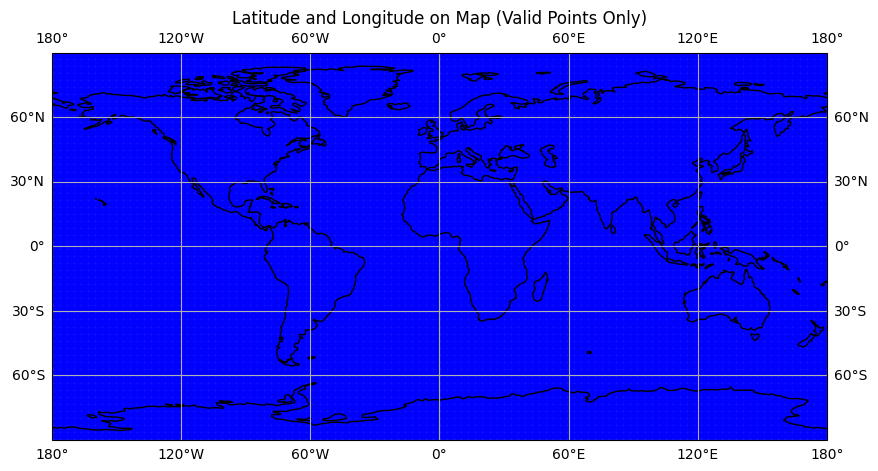

In [135]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Open the Zarr dataset in read-only mode
ds = zarr.open('datasets/download.zarr', mode='r')

# Check if 'latitudes' and 'longitudes' exist in the dataset
if 'latitudes' in ds and 'longitudes' in ds:
    latitudes = ds['latitudes'][:]
    longitudes = ds['longitudes'][:]
    
    # Check the shape of latitudes and longitudes
    print(f"Latitudes shape: {latitudes.shape}")
    print(f"Longitudes shape: {longitudes.shape}")

    # Create a mask where both latitudes and longitudes are valid (non-NaN)
    mask = np.isfinite(latitudes) & np.isfinite(longitudes)
    
    # Apply the mask to get only valid latitudes and longitudes
    valid_latitudes = latitudes[mask]
    valid_longitudes = longitudes[mask]
    
    # Count how many valid points (where both lat and lon are numbers)
    valid_points_count = np.sum(mask)
    print(f"Number of valid points (where both latitude and longitude are numbers): {valid_points_count}")

    # Calculate and print min/max for valid latitudes and longitudes
    min_latitude = np.min(valid_latitudes)
    max_latitude = np.max(valid_latitudes)
    min_longitude = np.min(valid_longitudes)
    max_longitude = np.max(valid_longitudes)

    print(f"Minimum Latitude: {min_latitude}")
    print(f"Maximum Latitude: {max_latitude}")
    print(f"Minimum Longitude: {min_longitude}")
    print(f"Maximum Longitude: {max_longitude}")

    # Create a map with Cartopy
    fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})

    # Add natural features to the map for context
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Scatter plot for latitude and longitude on the map
    sc = ax.scatter(valid_longitudes, valid_latitudes, s=0.1, color='blue', alpha=0.5, transform=ccrs.PlateCarree())

    # Add a title
    plt.title('Latitude and Longitude on Map (Valid Points Only)')

    # Show the plot
    plt.show()

else:
    print("Error: 'latitudes' or 'longitudes' not found in the dataset.")

## The dataset had duplicate points at the poles!

In [118]:
import xarray as xr
import numpy as np
import os
import dask.array as da
import logging
import traceback # Import traceback for printing full error details

# Configure logging for better visibility during script execution
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
LOG = logging.getLogger(__name__)

# Define input and output Zarr paths based on your previous `ls` output
input_zarr_path = "datasets/download.zarr"
output_zarr_path = "datasets/download_cleaned.zarr"  # This will overwrite the original dataset

# Define the number of decimal places for rounding coordinates
ROUND_DECIMALS = 7

def normalize_longitude(lon):
    """
    Normalizes longitudes to the range [-180, 180).
    E.g., 360 -> 0, 180 -> -180, 270 -> -90
    This function is designed to work correctly with both NumPy and Dask arrays.
    """
    return (lon + 180) % 360 - 180

try:
    # Open the Zarr dataset. Using `consolidated=False` for broader compatibility.
    ds = xr.open_zarr(input_zarr_path, consolidated=False)
    LOG.info(f"Opened Zarr dataset from {input_zarr_path}")

    # Verify and set 'latitudes' and 'longitudes' as coordinates.
    # This is crucial for xarray to correctly interpret spatial dimensions.
    if 'latitudes' in ds.data_vars and 'longitudes' in ds.data_vars:
        ds = ds.set_coords(['latitudes', 'longitudes'])
        LOG.info("Successfully moved 'latitudes' and 'longitudes' from data_vars to coordinates.")
    elif 'latitudes' in ds.coords and 'longitudes' in ds.coords:
        LOG.info("'latitudes' and 'longitudes' are already coordinates.")
    else:
        # Raise a ValueError if essential coordinates are missing.
        LOG.error(f"Error: 'latitudes' or 'longitudes' not found as data variables or coordinates in {input_zarr_path}.")
        LOG.error(f"Available data variables are: {list(ds.data_vars.keys())}")
        LOG.error(f"Available coordinates are: {list(ds.coords.keys())}")
        raise ValueError("Missing 'latitudes' or 'longitudes' coordinates. Cannot proceed with processing.")

    LOG.info(f"Normalizing longitudes to [-180, 180) and rounding to {ROUND_DECIMALS} decimal places...")

    # Access the underlying Dask arrays for original latitudes and longitudes.
    # These are assumed to be 1D arrays corresponding to the 'cell' dimension.
    longitudes_dask_original = ds['longitudes'].data
    latitudes_dask_original = ds['latitudes'].data

    # Apply longitude normalization and rounding operations lazily on Dask arrays.
    normalized_lons_dask = normalize_longitude(longitudes_dask_original)
    normalized_lons_dask = da.round(normalized_lons_dask, ROUND_DECIMALS)

    # Round latitudes lazily.
    latitudes_dask_rounded = da.round(latitudes_dask_original, ROUND_DECIMALS)

    # Create a 1D Dask boolean mask for valid coordinate points.
    # This mask checks for NaNs and specific boundary values (90, -90 for latitude; 180 for longitude).
    coord_mask_dask = (da.isfinite(latitudes_dask_rounded) & da.isfinite(normalized_lons_dask) &
                       (latitudes_dask_rounded != 90) & (latitudes_dask_rounded != -90) &
                       (normalized_lons_dask != 180))

    # *** IMPORTANT FIX FOR 'AttributeError: 'Array' object has no attribute 'data' ***
    # Compute the Dask boolean mask into a NumPy array *before* passing it to `isel`.
    # This avoids the internal xarray issue when using a Dask Array directly as an indexer.
    LOG.info("Computing coordinate mask to NumPy array...")
    coord_mask_np = coord_mask_dask.compute()

    # Apply the coordinate mask to the dataset using the 'cell' dimension.
    # The `isel` method with a NumPy boolean mask will select only the cells where `coord_mask_np` is True.
    # xarray automatically handles filtering all data variables and other coordinates
    # that depend on the 'cell' dimension.
    LOG.info("Applying mask to filter dataset along 'cell' dimension...")
    cleaned_ds = ds.isel(cell=coord_mask_np)

    # Update the 'latitudes' and 'longitudes' coordinates in the 'cleaned_ds'.
    # We apply the same `coord_mask_np` to the rounded Dask arrays,
    # and then call `.compute()` to get the final NumPy arrays for assignment.
    LOG.info("Updating latitudes and longitudes coordinates in the cleaned dataset...")
    cleaned_ds.coords['latitudes'] = (('cell',), latitudes_dask_rounded[coord_mask_dask].compute())
    cleaned_ds.coords['longitudes'] = (('cell',), normalized_lons_dask[coord_mask_dask].compute())

    LOG.info(f"Number of points after cleaning: {len(cleaned_ds['latitudes'])}")

    LOG.info(f"Overwriting original Zarr dataset at {output_zarr_path}...")
    # Save the cleaned dataset back to Zarr.
    # xarray handles the underlying Dask computations during this step, writing out the filtered data.
    # `mode='w'` ensures overwriting, and `consolidated=False` is used for compatibility.
    cleaned_ds.to_zarr(output_zarr_path, mode='w', consolidated=False)
    LOG.info("Cleaned, normalized, and rounded dataset saved successfully.")
    LOG.info(f"The cleaned dataset is now saved as {output_zarr_path}.")

except Exception as e:
    LOG.error(f"An error occurred during Zarr dataset processing: {e}")
    # Print the full traceback for detailed debugging information.
    traceback.print_exc()

INFO: Opened Zarr dataset from datasets/download.zarr
INFO: Successfully moved 'latitudes' and 'longitudes' from data_vars to coordinates.
INFO: Normalizing longitudes to [-180, 180) and rounding to 7 decimal places...
INFO: Computing coordinate mask to NumPy array...
INFO: Applying mask to filter dataset along 'cell' dimension...
INFO: Updating latitudes and longitudes coordinates in the cleaned dataset...
INFO: Number of points after cleaning: 1033202
INFO: Overwriting original Zarr dataset at datasets/download_cleaned.zarr...
INFO: Cleaned, normalized, and rounded dataset saved successfully.
INFO: The cleaned dataset is now saved as datasets/download_cleaned.zarr.


### Extending Dataset

In [115]:
import xarray as xr
import numpy as np

# Open the dataset
input_zarr_path = "datasets/download.zarr"
#input_zarr_path = "datasets/download_with_time.zarr"
zarr.consolidate_metadata(input_zarr_path)

ds = xr.open_zarr(input_zarr_path)

# Check the types of latitude, longitude, and time
latitudes = ds['latitudes'][:]
longitudes = ds['longitudes'][:]

# Check the type of latitudes and longitudes
print(f"Latitude dtype: {latitudes.dtype}")
print(f"Longitude dtype: {longitudes.dtype}")

# Check if there is a time variable in the dataset
if 'time' in ds:
    time = ds['time'][:]
    print(f"Time dtype: {time.dtype}")
else:
    print("No 'time' variable found in the dataset.")


Latitude dtype: float64
Longitude dtype: float64
Time dtype: datetime64[ns]


In [106]:
import xarray as xr
import pandas as pd
import numpy as np
import os

# Path to the Zarr dataset
input_zarr_path = 'datasets/download.zarr'

# Define time-related parameters (modify according to your dataset's needs)
start_date = '2024-03-01'  # Example start date
end_date = '2024-03-01'  # Example end date, could be a range or one-time step
time_frequency = 'h'  # Time frequency, e.g., hourly ('h')

# Create a time range using pandas
time_range = pd.date_range(start=start_date, end=end_date, freq=time_frequency)

try:
    # Open the Zarr dataset
    ds = xr.open_zarr(input_zarr_path, consolidated=False)
    print(f"Opened Zarr dataset from {input_zarr_path}")

    # Check if the dataset has a 'time' dimension
    if 'time' in ds.coords:
        print("Time dimension already exists in the dataset.")
        
        # Check if the time variable is empty or not properly defined
        if ds['time'].size == 0 or np.all(np.isnan(ds['time'].values)):
            print("Time dimension exists but is empty or invalid. Updating time variable.")
            # Assign the correct time values to the 'time' dimension
            ds.coords['time'] = ('time', time_range)
            print(f"Time variable updated with {len(time_range)} time points.")
        else:
            print("Time dimension exists and is already properly defined.")
    else:
        # Create a new time coordinate based on the generated time range
        ds.coords['time'] = ('time', time_range)
        print(f"Time variable added with {len(time_range)} time points.")

    # Save the updated dataset back to a new file to avoid overwriting the original one
    output_zarr_path = 'datasets/download_with_time.zarr'  # Save in a new file to avoid overwriting
    ds.to_zarr(output_zarr_path, mode='w', consolidated=False)
    print(f"Dataset with time variable added successfully, saved to {output_zarr_path}.")

except Exception as e:
    print(f"Error processing Zarr dataset: {e}")


Opened Zarr dataset from datasets/download.zarr
Time dimension already exists in the dataset.
Time dimension exists and is already properly defined.
Dataset with time variable added successfully, saved to datasets/download_with_time.zarr.


In [116]:
import zarr

input_zarr_path = "datasets/download.zarr"
zarr.consolidate_metadata(input_zarr_path)
print("Metadata consolidated.")


Metadata consolidated.


In [133]:
import xarray as xr
import numpy as np

# Open the Zarr dataset in read-only mode
input_zarr_path = "datasets/download.zarr"
#input_zarr_path = "datasets/download_cleaned.zarr"
zarr.consolidate_metadata(input_zarr_path)
ds = xr.open_zarr(input_zarr_path) 

# Check if latitudes and longitudes exist
if 'latitudes' in ds and 'longitudes' in ds:
    # Convert Dask arrays to NumPy arrays
    latitudes = ds['latitudes'].values
    longitudes = ds['longitudes'].values
    print(f"Length of latitudes: {len(latitudes)}")
    print(f"Length of longitudes: {len(longitudes)}")
    print(f"Shape of 'data': {ds['data'].shape}")

    
    # Check for NaNs in latitudes and longitudes
    latitudes_nan_count = np.sum(np.isnan(latitudes))  # Using NumPy for NaN computation
    longitudes_nan_count = np.sum(np.isnan(longitudes))  # Using NumPy for NaN computation

    print(f"Number of NaN values in latitudes: {latitudes_nan_count}")
    print(f"Number of NaN values in longitudes: {longitudes_nan_count}")
    
else:
    print("Error: 'latitudes' or 'longitudes' not found in the dataset.")

# Check for NaNs in all data variables
total_nan_count = 0
for var_name in ['data']:
    data = ds[var_name].values  # Convert Dask to NumPy
    data_nan_count = np.sum(np.isnan(data))  # Using NumPy for NaN computation
    print(f"Number of NaN values in '{var_name}': {data_nan_count}")
    total_nan_count += data_nan_count

print(f"Total number of NaN values in the dataset: {total_nan_count}")


Length of latitudes: 1033202
Length of longitudes: 1033202
Shape of 'data': (2, 1, 1, 1033202)
Number of NaN values in latitudes: 0
Number of NaN values in longitudes: 0
Number of NaN values in 'data': 0
Total number of NaN values in the dataset: 0


In [134]:
import xarray as xr

# Open the Zarr dataset
input_zarr_path = "datasets/download.zarr"
ds = xr.open_zarr(input_zarr_path)

# Check the content of 'dates'
dates = ds['dates'].values  # Get the dates as a NumPy array
print("Dates variable content:", dates)


Dates variable content: ['2024-03-01T12:00:00.000000000' '2024-03-02T12:00:00.000000000']


In [132]:
import shutil
import os

# Remove the existing download.zarr directory
shutil.rmtree('datasets/download.zarr')

# Rename the cleaned dataset to download.zarr
os.rename('datasets/download_cleaned.zarr', 'datasets/download.zarr')

### Visualize Datasets Differences

INFO: Successfully opened Zarr dataset: datasets/download.zarr


Attempting to open Zarr dataset from: datasets/download.zarr

--- Dataset Structure from xarray.open_zarr ---
<xarray.Dataset> Size: 25MB
Dimensions:     (variable: 1, time: 2, ensemble: 1, cell: 1033202)
Coordinates:
    latitudes   (cell) float64 8MB dask.array<chunksize=(64576,), meta=np.ndarray>
    longitudes  (cell) float64 8MB dask.array<chunksize=(64576,), meta=np.ndarray>
Dimensions without coordinates: variable, time, ensemble, cell
Data variables:
    count       (variable) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    data        (time, variable, ensemble, cell) float32 8MB dask.array<chunksize=(1, 1, 1, 1033202), meta=np.ndarray>
    dates       (time) datetime64[ns] 16B dask.array<chunksize=(2,), meta=np.ndarray>
    has_nans    (variable) bool 1B dask.array<chunksize=(1,), meta=np.ndarray>
    maximum     (variable) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    mean        (variable) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    min

INFO: Plotting unstructured grid data with scatter.
/home/rolan/all/ropy_wsl/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


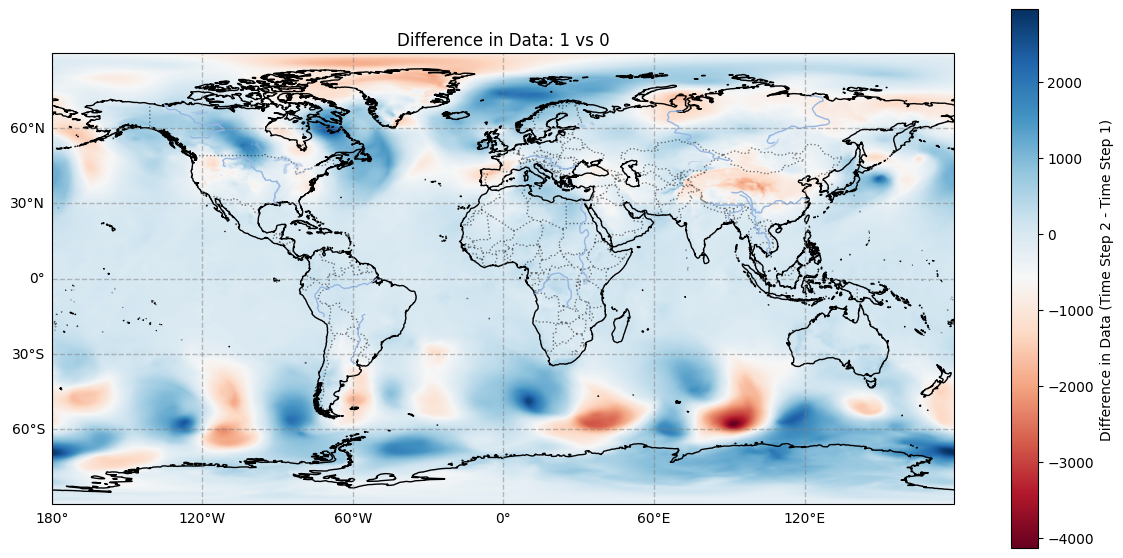

In [142]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature # Import cartopy.feature directly
import os
import logging
import traceback # Import traceback for detailed error reporting

# Configure logging for better visibility
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(name)s: %(message)s')
LOG = logging.getLogger(__name__)

# Define the path to your Zarr dataset
zarr_file_path = "datasets/download.zarr"

print(f"Attempting to open Zarr dataset from: {zarr_file_path}")

try:
    # Open the Zarr dataset using xarray
    # consolidated=False is often safer for Zarrs not created with consolidation
    ds = xr.open_zarr(zarr_file_path, consolidated=False)
    LOG.info(f"Successfully opened Zarr dataset: {zarr_file_path}")
    print("\n--- Dataset Structure from xarray.open_zarr ---")
    print(ds) # This will show the full dataset structure (dimensions, coordinates, data variables)

    # --- Data Preparation ---
    # Identify the main variable, now named 'data'
    if 'data' not in ds.data_vars:
        raise ValueError(f"Variable 'data' not found in dataset. Available data variables: {list(ds.data_vars.keys())}")
    
    # Identify latitude and longitude coordinates
    if 'latitudes' not in ds.coords or 'longitudes' not in ds.coords:
        raise ValueError(f"'latitudes' or 'longitudes' not found as coordinates. Available coordinates: {list(ds.coords.keys())}")

    # Identify the time dimension. Common names are 'time', 'valid_time', 'date'.
    time_dim_name = None
    # Prioritize 'valid_time' if it exists, as seen in era_t2m.nc output
    if 'valid_time' in ds.dims:
        time_dim_name = 'valid_time'
    else: # Fallback to generic search
        for dim in ds.dims:
            if 'time' in str(dim).lower() or 'date' in str(dim).lower():
                time_dim_name = dim
                break
    
    # Final check for time dimension
    if time_dim_name is None:
        # If no explicit time dimension is found in ds.dims, check if 'data' has a time-like dimension
        if ds['data'].dims and len(ds['data'].dims) > 1:
            # Assume the first dimension of 'data' is time if no explicit time_dim_name
            # This is a heuristic and might need to be adjusted based on your data's actual structure
            time_dim_name = ds['data'].dims[0]
            LOG.warning(f"No explicit time dimension found in dataset. Assuming '{time_dim_name}' is the time dimension for 'data'.")
        else:
            raise ValueError("No identifiable time dimension found in the dataset for 'data'.")

    # Ensure there are at least two time steps
    if ds[time_dim_name].size < 2:
        raise ValueError(f"Dataset only has {ds[time_dim_name].size} time step(s). Need at least two for difference visualization.")

    # Select the 'data' variable
    main_data_var = ds['data']

    # --- IMPORTANT FIX: Select specific indices for 'variable' and 'ensemble' dimensions ---
    # This ensures the resulting data is 1D (along 'cell') after time selection.
    selection_indices_step1 = {time_dim_name: 0}
    selection_indices_step2 = {time_dim_name: 1}

    # Add 'variable' and 'ensemble' dimensions to selection if they exist in 'data'
    if 'variable' in main_data_var.dims:
        selection_indices_step1['variable'] = 0
        selection_indices_step2['variable'] = 0
    if 'ensemble' in main_data_var.dims:
        selection_indices_step1['ensemble'] = 0
        selection_indices_step2['ensemble'] = 0

    data_time_step_1 = main_data_var.isel(selection_indices_step1)
    data_time_step_2 = main_data_var.isel(selection_indices_step2)

    # Get the actual datetime values for the title
    time_val_1 = ds[time_dim_name].isel({time_dim_name: 0}).item()
    time_val_2 = ds[time_dim_name].isel({time_dim_name: 1}).item()

    # Calculate the difference
    # xarray handles alignment, so direct subtraction works
    difference = data_time_step_2 - data_time_step_1

    # --- Debugging Prints for Difference Array ---
    print(f"\n--- Debugging 'difference' DataArray ---")
    print(f"Difference DataArray: {difference}")
    print(f"Difference dimensions: {difference.dims}")
    print(f"Difference shape: {difference.shape}")
    print(f"Difference values (NumPy array) shape: {difference.values.shape}")
    print(f"Difference values (NumPy array) ndim: {difference.values.ndim}")
    # --- End Debugging Prints ---

    # Get the 1D latitude and longitude arrays corresponding to the spatial dimension
    # These are needed for both structured and unstructured plotting
    lats_coords = ds['latitudes'].values
    lons_coords = ds['longitudes'].values

    # Convert difference data to a NumPy array for plotting
    diff_np = difference.values

    # --- Visualization ---
    print("\n--- Generating Visualization of Differences ---")

    fig = plt.figure(figsize=(12, 8))
    # Use PlateCarree projection for simple lat/lon data
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Determine plotting method based on the dimensions of the 'difference' DataArray
    if 'latitude' in difference.dims and 'longitude' in difference.dims:
        # Case 1: Structured grid (difference has latitude and longitude as dimensions)
        LOG.info("Plotting structured grid data with pcolormesh.")
        # Use the coordinates directly from the 'difference' DataArray for pcolormesh
        plot = ax.pcolormesh(difference.longitude, difference.latitude, diff_np, cmap='RdBu', transform=ccrs.PlateCarree())
        ax.set_extent([np.min(difference.longitude), np.max(difference.longitude), np.min(difference.latitude), np.max(difference.latitude)], crs=ccrs.PlateCarree())
    elif 'cell' in difference.dims: # Assuming 'cell' is the single spatial dimension for unstructured data
        # Case 2: Unstructured grid (difference has 'cell' as its spatial dimension)
        LOG.info("Plotting unstructured grid data with scatter.")
        # Ensure that lons_coords and lats_coords are aligned with the 'cell' dimension of difference
        # The check `diff_np.ndim == 1` is crucial here.
        if diff_np.ndim == 1 and len(diff_np) == len(lats_coords) and len(diff_np) == len(lons_coords):
            plot = ax.scatter(lons_coords, lats_coords, c=diff_np, cmap='RdBu', s=1, transform=ccrs.PlateCarree())
            ax.set_extent([np.min(lons_coords), np.max(lons_coords), np.min(lats_coords), np.max(lats_coords)], crs=ccrs.PlateCarree())
        else:
            # This error means the data is NOT 1D as expected for scatter, or lengths don't match
            # This case should now ideally not be hit if 'variable' and 'ensemble' are correctly selected
            raise ValueError(f"Data variable 'data' difference has dimensions {difference.dims} and shape {difference.shape}. Expected 1D for scatter plot with 'cell' dimension, but got ndim={diff_np.ndim} and len={len(diff_np)} vs coords len={len(lats_coords)}. Check if 'data' is truly (time, variable, ensemble, cell) and selection is correct.")
    else:
        # If neither structured (lat, lon) nor unstructured (cell) dimensions are found
        raise ValueError(f"Unsupported data structure for plotting. 'data' difference has dimensions: {difference.dims}. Expected (latitude, longitude) or (cell).")

    # Add geographical features using the correct cartopy.feature module
    ax.coastlines(resolution='50m', color='black')
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5) # Corrected: cfeature.BORDERS
    ax.add_feature(cfeature.LAKES, alpha=0.5) # Corrected: cfeature.LAKES
    ax.add_feature(cfeature.RIVERS) # Corrected: cfeature.RIVERS
    
    # Add gridlines with labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Add a colorbar
    cbar = plt.colorbar(plot, ax=ax, orientation='vertical', pad=0.05, shrink=0.7, label='Difference in Data (Time Step 2 - Time Step 1)')

    # Set title
    plt.title(f'Difference in Data: {time_val_2} vs {time_val_1}')

    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

except FileNotFoundError:
    LOG.error(f"Error: The Zarr archive '{zarr_file_path}' was not found. Please check the path.")
except ValueError as ve:
    LOG.error(f"Data structure error: {ve}")
    traceback.print_exc()
except Exception as e:
    LOG.error(f"An unexpected error occurred during visualization: {e}")
    traceback.print_exc()
